In [1]:
from torch.distributions import Uniform
from sbi.utils import CustomDistribution

def sample_prior(num_samples):
    samples = []
    while len(samples) < num_samples:
        theta = torch.stack([Uniform(a1, b1).sample((1,)), Uniform(a2, b2).sample((1,))]).squeeze()
        if theta[0] + theta[1] < 10:  # Apply constraint
            samples.append(theta)
    return torch.stack(samples)

prior = CustomDistribution(sample=sample_prior)

ImportError: cannot import name 'CustomDistribution' from 'sbi.utils' (/Volumes/External/Research/Regan/TecateCypress/model_fitting/sbi/utils/__init__.py)

In [2]:
import torch
from torch.distributions import Uniform, Distribution
from sbi import utils

class CustomPrior(Distribution):
    def __init__(self):
        super().__init__()
        self.base_dist = Uniform(torch.tensor([0.0, 0.0]), torch.tensor([10.0, 10.0]))  # Example bounds

    def sample(self, sample_shape=torch.Size()):
        num_samples = sample_shape[0] if len(sample_shape) > 0 else 1
        samples = []
        while len(samples) < num_samples:
            theta = self.base_dist.sample()
            if theta[0] + theta[1] < 10:  # Constraint example: θ₁ + θ₂ < 10
                samples.append(theta)
        return torch.stack(samples)

    def log_prob(self, theta):
        # Return -inf if constraint is violated, otherwise use base log prob
        mask = (theta[:, 0] + theta[:, 1] < 10)
        log_prob = self.base_dist.log_prob(theta).sum(dim=-1)  # Sum over dimensions
        log_prob[~mask] = -float("inf")  # Enforce constraint
        return log_prob

prior = CustomPrior()

/Users/patrick/miniconda3/envs/sbi_env/lib/python3.11/site-packages/torch/distributions/distribution.py:53: UserWarning: <class '__main__.CustomPrior'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [36]:
import numpy as np
fn = 'fecundity/observations/observations.npy'
x_o = np.load(fn)

In [37]:
x_o

array([  0.61357143,  67.12187356, 180.59239487,   0.51422479,
        59.3602355 , 166.45246727])

In [73]:
np.arange(3)**2

array([0, 1, 4])

In [ ]:
theta[:,2] - ((1 / theta[:,3]) * np.log(np.exp(theta[:,1]**2 / 2)*theta[:,0] - 1))

In [6]:
import pickle
with open('fecundity/prior.pkl', 'rb') as handle:
    prior = pickle.load(handle)

In [ ]:
prior.sample()

In [46]:
import torch
from torch.distributions import Uniform, Distribution
from torch import tensor
from sbi import utils

ranges = [[0., 10.], [0., 10.]]
priors = [Uniform(tensor([rng[0]]), tensor([rng[1]])) for rng in ranges]

class CustomPrior(Distribution):
    def __init__(self):
        super().__init__()
        self.base_dist = Uniform(tensor([rng[0] for rng in ranges]), tensor([rng[1] for rng in ranges]))

    def sample(self, sample_shape=torch.Size()):
        num_samples = sample_shape[0] if len(sample_shape) > 0 else 1
        samples = []
        while len(samples) < num_samples:
            theta = self.base_dist.sample()
            if theta[0] + theta[1] < 10:  # Constraint example: θ₁ + θ₂ < 10
                samples.append(theta)
        return torch.stack(samples)

    def log_prob(self, theta):
        # Return -inf if constraint is violated, otherwise use base log prob
        mask = (theta[:, 0] + theta[:, 1] < 10)
        log_prob = self.base_dist.log_prob(theta).sum(dim=-1)  # Sum over dimensions
        log_prob[~mask] = -float("inf")  # Enforce constraint
        return log_prob

prior = CustomPrior()

In [48]:
theta = prior.sample(); theta

tensor([[4.1407, 0.4943]])

In [49]:
theta.shape

torch.Size([1, 2])

In [3]:
prior.log_prob(theta)

tensor([-4.6052])

In [4]:
prior, theta_numel, prior_returns_numpy = utils.user_input_checks.process_prior(prior)

In [5]:
prior.sample()

tensor([[2.8588, 6.2519]])

In [131]:
import numpy as np
import torch
from torch.distributions import Uniform, Distribution
from torch import tensor
from sbi import utils
import pickle as pickle
pr = 'fecundity'
ranges = np.array([
                   [10, 600],
                   [0.01, 0.8],
                   [15, 80],
                   [0.01, 6]
])

custom_bin_edges = np.load(pr + '/observations/custom_bin_edges.npy')
a_star_target = 20
a_star_i = np.argmin(np.abs(a_star_target - custom_bin_edges))
a_star = custom_bin_edges[a_star_i]
class CustomPrior(Distribution):
    def __init__(self):
        super().__init__()
        self.base_dist = Uniform(tensor([rng[0] for rng in ranges]), tensor([rng[1] for rng in ranges]))

    def sample(self, sample_shape=torch.Size()):
        num_samples = sample_shape[0] if len(sample_shape) > 0 else 1
        samples = []
        while len(samples) < num_samples:
            theta = self.base_dist.sample()
            constraint_check = theta[2] - ((1 / theta[3]) * torch.log(torch.exp(theta[1]**2 / 2) * theta[0] - 1))
            #if theta[0] + theta[1] < 10:  # Constraint example: θ₁ + θ₂ < 10
            if a_star <= constraint_check:
                samples.append(theta)
        if len(sample_shape) == 0:
            return samples[0]
        else:
            return torch.stack(samples)

    def log_prob(self, theta):
        sample_shape = theta.shape
        # Return -inf if constraint is violated, otherwise use base log prob
        if len(sample_shape) == 1:
            constraint_check = theta[2] - ((1 / theta[3]) * torch.log(torch.exp(theta[1]**2 / 2) * theta[0] - 1))
            success = (a_star <= constraint_check)
            if success:
                log_prob = self.base_dist.log_prob(theta).sum(dim=-1)  # Sum over dimensions
            else:
                log_prob = -float("inf")  # Enforce constraint
            return tensor([log_prob])
        else:
            constraint_check = theta[:, 2] - ((1 / theta[:, 3]) * torch.log(torch.exp(theta[:, 1]**2 / 2) * theta[:, 0] - 1))
            mask = (a_star <= constraint_check)
            log_prob = self.base_dist.log_prob(theta).sum(dim=-1)  # Sum over dimensions
            log_prob[~mask] = -float("inf")  # Enforce constraint
            return log_prob

prior = CustomPrior()
prior, theta_numel, prior_returns_numpy = utils.user_input_checks.process_prior(prior)

In [132]:
prior_sample = prior.sample((2,))
prior.log_prob(prior_sample)

tensor([-12.1089, -12.1089])

In [133]:
len(prior_sample.shape)

2

In [134]:
prior_sample = prior.sample()
prior.log_prob(prior_sample)

tensor([-12.1089])

In [135]:
len(prior_sample.shape)

1

In [136]:
prior.sample((1,)).shape

torch.Size([1, 4])

In [139]:
from fecundity.simulator import simulator, save_observations
from sbi.inference import simulate_for_sbi
simulator = utils.user_input_checks.process_simulator(simulator, prior, is_numpy_simulator=True)
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=10, num_workers=1)

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

In [113]:
with open('mortality/prior.pkl', 'rb') as handle:
    prior = pickle.load(handle)
print(prior.sample())
prior, theta_numel, prior_returns_numpy = utils.user_input_checks.process_prior(prior)
print(prior.sample())
from mortality.simulator import simulator

tensor([0.3441, 0.3862, 0.6494])
tensor([0.1754, 0.2679, 1.3227])


In [114]:
prior.log_prob(prior.sample())

tensor([0.0176])

## Model fitting

In [1]:
import torch
import numpy as np
import scipy
import pickle
from pandas import read_csv
from matplotlib import pyplot as plt
from sbi import utils as utils

/var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T/ipykernel_68222/3001828504.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  from pandas import read_csv


### Mortality 

In [16]:
from mortality.simulator import simulator

# Read in mortality observations
fn = 'mortality/observations/mortality.csv'
mortality_o = read_csv(fn, header=None)
mortality_o[0] = [round(v) for v in mortality_o[0]]
# Define census years
census_yrs = [2,6,8,11,14]

# Get mean value of morality params over a bunch of posterior samples
pr = 'mortality'
num_posterior_samples = 1000
with open(pr+'/prior.pkl', 'rb') as handle:
    prior = pickle.load(handle)
prior, theta_numel, prior_returns_numpy = utils.user_input_checks.process_prior(prior)
simulator = utils.user_input_checks.process_simulator(simulator, prior, is_numpy_simulator=True)
x_o = np.load(pr+'/observations/observations.npy')
x_o = torch.Tensor(x_o)
with open(pr+"/posterior.pkl", "rb") as handle:
    posterior = pickle.load(handle)
posterior_samples = posterior.sample(sample_shape=(1000,))
x_pp = simulator(posterior_samples)
x_pp = x_pp[~torch.any(x_pp.isnan(),dim=1)].numpy()
x_pp_mean = np.mean(x_pp, axis=0)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/Volumes/External/Research/Regan/TecateCypress/model_fitting/mortality/simulator.py:79: RuntimeWarning: overflow encountered in exp
  dens_dep = ((nu_a[age_i])*(1-m_a[age_i])) / (1 + np.exp(-eta_a[age_i]*K_adult*(N/K_a[age_i] - A_o*h_o)))
/Volumes/External/Research/Regan/TecateCypress/model_fitting/mortality/simulator.py:79: RuntimeWarning: overflow encountered in exp
  dens_dep = ((nu_a[age_i])*(1-m_a[age_i])) / (1 + np.exp(-eta_a[age_i]*K_adult*(N/K_a[age_i] - A_o*h_o)))


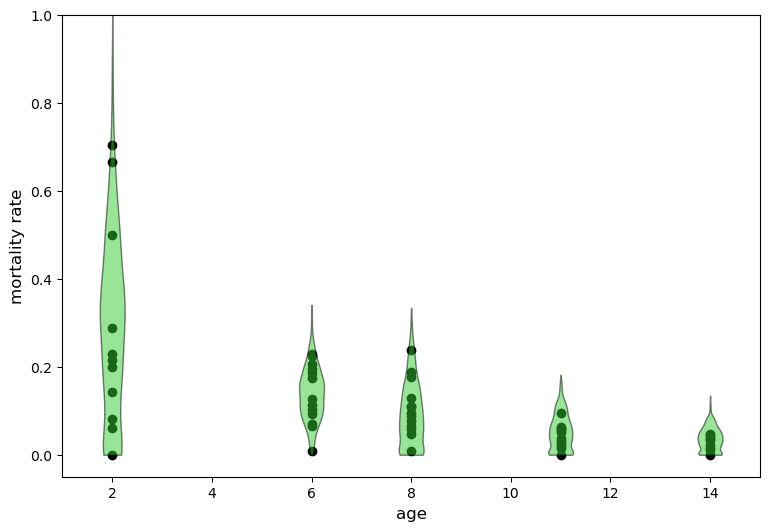

In [20]:
# Draw the distributions based on the above averages parameters for plotting
samples_per_census = 1000
all_y = []
for census_i, census_t in enumerate(census_yrs):
    mean = x_pp_mean[census_i]
    var = x_pp_mean[census_i + 5]
    skew = x_pp_mean[census_i + 10]
    dist_samples = scipy.stats.skewnorm.rvs(skew, loc=mean, scale=np.sqrt(var), size=samples_per_census)
    all_y.append(np.where(dist_samples<0, 0, dist_samples))

fig, ax = plt.subplots(1, figsize=(9,6))
ax_fontsize = 12

ax.scatter(mortality_o[0].to_numpy(), mortality_o[1].to_numpy(), color='k')

parts = ax.violinplot(all_y, positions=census_yrs, showextrema=False);
for pc in parts['bodies']:
    pc.set_facecolor('limegreen')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)

ax.set_ylim(-0.05, 1)
ax.set_xlim(1,15)
ax.set_ylabel("mortality rate", fontsize=ax_fontsize)
ax.set_xlabel("age", fontsize=ax_fontsize)
fn = f"sbi_figs/mortality_viz.png"
# fig.savefig(fn, bbox_inches='tight')

### Fecundity

In [2]:
from fecundity.simulator import simulator
import json

In [3]:
# Read in coarse grained fecundity observations
observations = np.load('fecundity/observations/observations.npy')
binwidth = 22
age_cntrs = np.array([binwidth*i + binwidth/2 for i in range(3)])

from fecundity.simulator import simulator
pr = 'fecundity'
x_o = np.load(pr+'/observations/observations.npy')
x_o = torch.Tensor(x_o)
with open(pr+"/posterior.pkl", "rb") as handle:
    posterior = pickle.load(handle)
posterior_samples = posterior.sample(sample_shape=(1000,)).numpy()
x_pp = np.ones((posterior_samples.shape[0], 7)) * np.nan
for sample_i, sample in enumerate(posterior_samples):
    x_pp[sample_i] = simulator(sample)
x_pp = x_pp[~np.any(np.isnan(x_pp), axis=1)]
x_pp_mean = np.mean(x_pp, axis=0)

# # Get mean value of fecundity params over a bunch of posterior samples
# from fecundity.simulator import simulator
# pr = 'fecundity'
# x_o = np.load(pr+'/observations/observations.npy')
# x_o = torch.Tensor(x_o)
# with open(pr+"/posterior.pkl", "rb") as handle:
#     posterior = pickle.load(handle)
# posterior_samples = posterior.sample(sample_shape=(1000,)).numpy()
# x_pp = np.ones((posterior_samples.shape[0], 7)) * np.nan
# for sample_i, sample in enumerate(posterior_samples):
#     x_pp[sample_i] = simulator(sample)
# x_pp = x_pp[~np.any(np.isnan(x_pp), axis=1)]
# x_pp_mean = np.mean(x_pp, axis=0)

# Try just looking at map instead
with open('../model_fitting/fecundity/map.json', 'r') as handle:
    fecundity_map = json.load(handle)
map_params = np.array(list(fecundity_map.values()))
x_pp = np.ones((posterior_samples.shape[0], 7)) * np.nan
for sample_i, sample in enumerate(posterior_samples):
    x_pp[sample_i] = simulator(map_params)
x_pp = x_pp[~np.any(np.isnan(x_pp), axis=1)]
x_pp_mean = np.mean(x_pp, axis=0)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

[  0   0   0   2   0   0  17   5  16  93  86 328 321  72 258  80 274  64
 412  17 362 335 661 265 958 148]
[  0   0   0   1   0   6   3   1  11  14  17  13  49 217  13 237 132  87
  38 220 162   9  92 120  76  33]
[  0   0   0   1   2   1   0   2   7   7  29 140  52 231 143 147 128 421
 224 332 233 362 290 137 374 223]
[   0    0    1    0    2   10   42   22   43   23   92   23   87  228
 1091  157  200  139  678  616   17  457  103   85    6  260]
[   1    0    0    8    3    7   10   24   27   28  184   21  220   55
  144  367 1161   56  441   47 1253  396  131  182  131   49]
[   0    0    0    3    0    0    6   42    3   14  167  488 1155   63
   43   57   21  124 1177   91  222   31  502  185  138  336]
[  0   0   0   3   0   0  11  16  16  18  31 171  28  71 117  97 149 354
 145 189  87 144 147 160 174  96]
[   0    0    0    0    0    0   18    0    3    3  226  135  134  101
 1461  293  330  263  970  131   90  324  123  150  445   91]
[  0   0   0   2   0   2   7   6   5  12

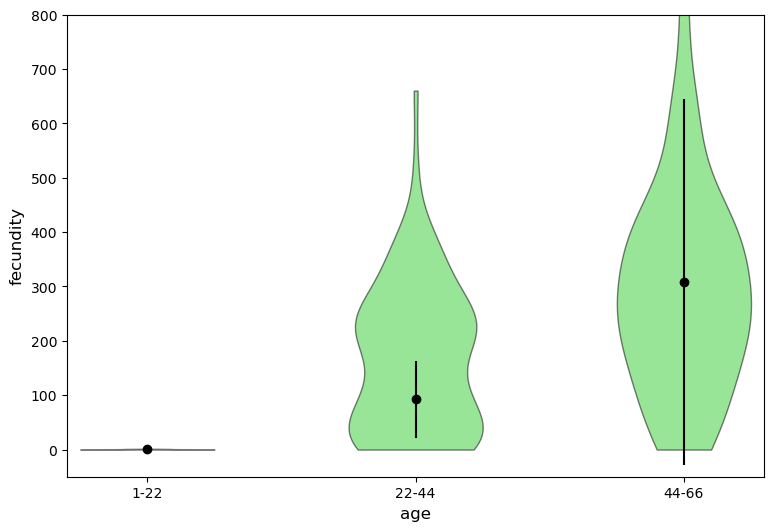

In [37]:
# Draw the distributions based on the above averages parameters for plotting
samples_per_census = 100
all_y = []
for census_i, census_t in enumerate(age_cntrs):
    mean = x_pp_mean[census_i]
    std = x_pp_mean[census_i + age_cntrs.size]
    dist_samples = scipy.stats.norm.rvs(loc=mean, scale=std, size=samples_per_census)
    all_y.append(np.where(dist_samples<0, 0, dist_samples))

fig, ax = plt.subplots(1, figsize=(9,6))
ax_fontsize = 12

ax.errorbar(range(3), observations[:age_cntrs.size], yerr=observations[age_cntrs.size:observations.size-1], 
            fmt='o', color='black')

parts = ax.violinplot(all_y, positions=range(3), showextrema=False, showmeans=False);
for pc in parts['bodies']:
    pc.set_facecolor('limegreen')
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    
xtick_labels = [f"1-{binwidth}", f"{binwidth}-{2*binwidth}", f"{2*binwidth}-{3*binwidth}"]
ax.set_xticks(range(3), labels=xtick_labels)
ax.set_xlabel("age", fontsize=ax_fontsize)
ax.set_ylabel("fecundity", fontsize=ax_fontsize)
ax.set_ylim(-50, 800)
ax.set_xlim(-0.3, 2.3)
fn = f"sbi_figs/fecundity_viz.png"
fig.savefig(fn, bbox_inches='tight')